# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Project Name： Facial Landmark Detection
Project mentor: Aditya

Kangyun Chen <kchen127@jh.edu>, Ruoling Fan <rfan10@jh.edu>, Honglin Zhu <hzhu55@jh.edu>, Zhengyuan Zhang <zzhan266@jh.edu>

Link_to_git_repo

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. "Expect to complete #3(Modify the loss function so that we can improve the model performance)": During the project, it is non-sense if we want to improve the model performance by changing the loss function. Since if the model is not reasonable, whatever loss functions we will use are useless. The loss function is used to check the model performance. Moreover, we need to change the model architecture if we want to improve the model performance.
2. "Would like to complete #1(Deformation Function)": Due to the time limit, we did not implement face deformation based on facial landmarks.  


### Completed Deliverables
1. "Must complete #1(Data preprocessing)": We discuss our dataset pre-processing [in "Dataset" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
2. "Must complete #2(Baseline model)": We design the convolution neural network model [in "Baselines" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
3. "Must complete #3(Visualize the predict result)": we visulize the prediction result [in "Result" below](#scrollTo=4FW4zZX47lyz&line=1&uniqifier=1)
4. "Expect to complete #1(Design a new model)": We design the convolution neural network + transformer model [in "Method" below](#scrollTo=PqB48IF9kMBf)
5. "Expect to complete #2(Comparison)": We compare the performance of CNN model and CNN+transformer Model [in "Result" below](#scrollTo=tYyYPeef8S5f&line=6&uniqifier=1) 
6. "Would like to complete #2(Try other data preprocessing way)": We use other way to preprocess the data [in "Pre-processing"](#scrollTo=XN1fYEfGidiD)
7. "Would like to complete #3(Design other new model)": We design the residual neural network [in "Method" below](#scrollTo=PqB48IF9kMBf)


### Additional Deliverables
1. We analyze the reasons of the different performance of the CNN, CNN+Transformer and Residual NN. We discuss this [in "Result" below](#scrollTo=RQIukeq68jDi&line=13&uniqifier=1).
2. We applied our model to reality, analyzing the facial pictures of our teammates and showing the prediction result. We discuss this [in "Result" below](#scrollTo=RQIukeq68jDi&line=13&uniqifier=1).

# Preliminaries

## What problem were you trying to solve or understand?

What are the real-world implications of this data and task?

How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?

What makes this problem unique?

What ethical implications does this problem have?

Facial landmark detection is the task of detecting key landmarks on the face, given the static facial images. As a fundamental component in face analysis, facial landmark detection is applied in many areas, such as facial recognition, facial positional tracking, and facial editing. In line with the recent success of neural networks, many methods are proposed to address this problem. However, developing a practical facial landmark detector remains challenging, as detection accuracy should always be a concern.
As a supervised and regression task, our project investigates the CNN-based approach and the combination of CNN and the Transformer. Moreover, to obtain more promising performance in facial landmark detection, we construct a residual neural network (RNN) model, which eventually displays a significant decrease in loss during the validation process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.utils.data as udata
import torch
import torch.nn as nn
import tensorflow as tf
import glob, cv2, os, tqdm
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.models import load_model
from keras import layers
from keras.layers import *
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.metrics import mean_absolute_error
from keras.utils import Sequence
from keras.utils import plot_model

seed = 42
np.random.seed(seed)

## Dataset(s)

Describe the dataset(s) you used.

How were they collected?

Why did you choose them?

How many examples in each?


The dataset we used is [YouTube Faces with Facial Keypoints](https://www.kaggle.com/datasets/selfishgene/youtube-faces-with-facial-keypoints). It contains over 2000 unique faces. Each unique face has tens to hundreds of facial images and corresponding landmarks stored in tensors with sizes (height, width, 3, n) and (68, 2, n), respectively, where n denotes the number of images of the current face. Therefore, in this dataset, images and landmarks are both sufficient for training and easy to load. 

In [ ]:
portion = 0.02 #Portion of images of a unique face to be selected
path_list = glob.glob('./archive/*/*/*.npz')
len(path_list) #Number of all unique faces

2195

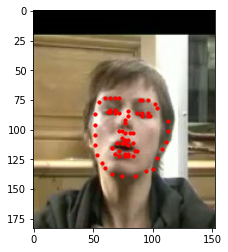

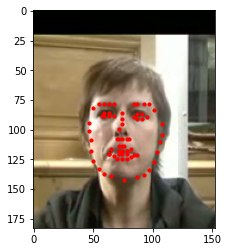

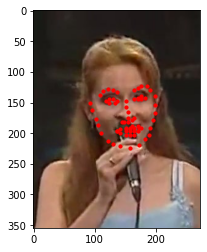

In [ ]:
#Load your data and print 2-3 examples
for idx, path in enumerate(path_list):
  data = np.load(path)
  imgs = data['colorImages']
  landmarks = data['landmarks2D']
  random_id = np.random.choice(np.arange(imgs.shape[-1]), size=int(imgs.shape[-1] * portion), replace=False)
  imgs, landmarks = imgs[..., random_id], landmarks[..., random_id]
  for i in range(imgs.shape[-1]):
    img = imgs[..., i]
    lm = landmarks[..., i]
    plt.imshow(img)
    plt.scatter(lm[:,0],lm[:,1],s=10,c="red")
    plt.show()
  if idx >= 2:
    break

## Pre-processing

What features did you use or choose not to use? Why?

If you have categorical labels, were your datasets class-balanced?

How did you deal with missing data? What about outliers?

What approach(es) did you use to pre-process your data? Why?

Are your features continuous or categorical? How do you treat these features differently?

The dataset for our project is loaded by selecting a certain proportion of images for each unique face, where the proportion number is learned experientially. In the selected dataset, there is neither missing data nor an outlier. Hence we directly take image data as inputs and landmark 2D coordinates as outputs.

However, since different facial images' sizes vary, we first need to make them consistent through a linear transformation. Meanwhile, landmarks should also be transformed to match the resized image since they are represented relative positions based on the current image. 

Therefore, after data pre-processing, each image is resized into a shape of (224, 224, 3), and corresponding landmarks are transformed to be consistent with the new size. 

In [ ]:
#Initial settings for pre-processing
height_max = 224 #resized image height
width_max = 224 #resized image width
batch_size = 32

In [ ]:
#Save images as jpg while landmarks as npz with identical indices
save_idx = 0
for idx, path in enumerate(path_list):
  data = np.load(path)
  imgs = data['colorImages']
  landmarks = data['landmarks2D']
  
  random_id = np.random.choice(np.arange(imgs.shape[-1]), size=int(imgs.shape[-1] * portion), replace=False)
  imgs, landmarks = imgs[..., random_id], landmarks[..., random_id]
    
  for i in range(imgs.shape[-1]):
    img = imgs[..., i]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    lm = landmarks[..., i]
    img_resize = cv2.resize(img,(height_max, width_max))
    lm_resize = lm[:,:] 
    height, width = img.shape[0], img.shape[1]
    lm_resize[:,0] = lm_resize[:,0] / width * width_max
    lm_resize[:,1] = lm_resize[:,1] / height * height_max

    cv2.imwrite('./dataset/image/{}.jpg'.format(save_idx), img_resize)
    np.save('./dataset/label/{}.npy'.format(save_idx), lm_resize)
    if save_idx%200 == 0:
      print(save_idx)
    save_idx += 1

In [ ]:
#Number of pre-processed images
print(save_idx-1)

12140


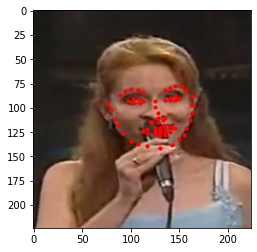

In [ ]:
#The resized version of the last image presented above
plt.imshow(img_resize[:,:,::-1])
plt.scatter(lm_resize[:,0],lm_resize[:,1],c="red",s=10)
plt.show()

It is worth noting that, data distributions are not changed in resizing procedure.

Data loader for CNN and CNN+Transformer models:

In [ ]:
class LandmarkDataset(udata.Dataset):
  def __init__(self, length, height_max, width_max):
    super(udata.Dataset, self).__init__()
    self.height_max = height_max
    self.width_max = width_max
    
    self.len = length
    self.path = np.arange(self.len)
  
  def __len__(self):
    return self.len

  def __getitem__(self, index):
    img = cv2.imread('./dataset/image/{}.jpg'.format(index))
    lm = np.load('./dataset/label/{}.npy'.format(index), allow_pickle=True)

    image = torch.from_numpy(img.astype('float32'))
    landmark = torch.from_numpy(lm.astype('float32'))
    return {"img":image, "lm":landmark}

In [ ]:
length = 12000
total_dataset = LandmarkDataset(length, height_max, width_max)
train_length = int(0.8*len(total_dataset))
val_test_length = len(total_dataset) - train_length
val_length = int(0.1*len(total_dataset))
test_length = val_test_length - val_length

In [ ]:
train_dataset, val_test_dataset = torch.utils.data.random_split(total_dataset,(train_length,val_test_length),generator=torch.Generator().manual_seed(seed))
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset,(val_length,test_length),generator=torch.Generator().manual_seed(seed))

num_workers = 2
train_loader = udata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
val_loader = udata.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=num_workers)
test_loader = udata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=num_workers)

Data loader for ResNet Model:

In [ ]:
class DataGenerator(Sequence):
  def __init__(self, path, img_size=224, batch_size=32, shuffle=True):
    with open(path) as f:
        self.path = np.array(list(map(lambda x:x.strip(), f.readlines())))
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.img_size = img_size
    self.index = np.arange(len(self.path))
  
  def __len__(self):
    return len(self.path) // self.batch_size
  
  def on_epoch_end(self):
    if self.shuffle == True:
      ]np.random.shuffle(self.index)
  
  def __getitem__(self, index):
    x, y = [], []
    for idx in self.path[self.index[index * self.batch_size:(index + 1) * self.batch_size]]:
      img = cv2.imread('./dataset/image/{}.jpg'.format(idx))
      label = np.load('./dataset/label/{}.npy'.format(idx), allow_pickle=True)

    x.append(img)
    y.append(label.reshape((-1)))
      
    return np.array(x, dtype=np.float64) / 255.0, np.array(y, dtype=np.float64) / self.img_size

In [ ]:
data_list = np.arange(save_idx).astype(str)
np.random.shuffle(data_list)

train = data_list[:int(len(data_list) * 0.8)]
val = data_list[int(len(data_list) * 0.8):int(len(data_list) * 0.9)]
test = data_list[int(len(data_list) * 0.9):]

with open('/content/drive/MyDrive/ML675 Final/train.txt', 'w+') as f:
    f.write('\n'.join(train))
with open('/content/drive/MyDrive/ML675 Final/val.txt', 'w+') as f:
    f.write('\n'.join(val))
with open('/content/drive/MyDrive/ML675 Final/test.txt', 'w+') as f:
    f.write('\n'.join(test))

It is notable that, for easier implementation of our ResNet Model, we design the data loader for ResNet seperately.

# Models and Evaluation

## Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

How did you split your data into train and test sets? Why?


We only applied Mean Square Loss (MSE) for the loss function to train our model since our task is supervised regression. 

We applied Normalized Mean Error (NME) for the evaluation metric derived from MSE, and a normalizer on face size was added for each unique face. Therefore, NME excludes the influence of variation of different facial sizes.

According to the data loaders above, we split our data into 8:1:1 training, testing, and validation sets for all three models.

In [ ]:
def NME(pred, landmark): #per batch
  assert pred.shape == landmark.shape
  nme = 0
  for i in range(pred.shape[0]):
    d = np.linalg.norm(landmark[i,36,:]-landmark[i,45,:])
    nme += np.linalg.norm(pred[i]-landmark[i])/d
  return nme/pred.shape[0]

In [ ]:
def validate(model, loader, criterion, demo=False, demo_num=2):
  model.eval()
  val_loss = 0
  val_metric = 0
  for batch, data in enumerate(loader):
    imgs_ = data["img"]
    imgs = torch.autograd.Variable(imgs_/255.0).permute(0,3,1,2).cuda()
    lms = data["lm"]
    output = model(imgs).cpu()
    loss = criterion(output.view(-1),lms.view(-1))
    val_loss += loss.item()
    val_metric += NME(output.view(-1,68,2).detach().numpy(),lms.numpy())
    if demo and batch < demo_num:
      pred = output[0].view(-1,2).detach().numpy()

      plt.imshow(imgs_[0].numpy()[:,:,::-1].astype('uint8'))
      plt.scatter(pred[:,0],pred[:,1],s=10,c="blue")
      plt.scatter(lms[0,:,0],lms[0,:,1],s=10,c="red")
      plt.show()

  return val_loss/len(loader), val_metric/len(loader)

In [ ]:
criterion = nn.MSELoss()

## Baselines 

What baselines did you compare against? Why are these reasonable?

Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?

We constructed a CNN model as our baseline. Intuitively, CNNs are applied to process image data. With plenty of convolutional layers, pooling layers, and activation layers, features of the input image are extracted. In the end, a vector representing 68 2D coordinates of landmarks will be generated. However, the model performed differently than we expected.

**Convolutional Neural Network:**

In [ ]:
class Model_CNN(nn.Module):
  def __init__(self):
    super(Model_CNN, self).__init__()

    self.dropout = nn.Dropout(0.05)
    self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=3)
    self.pool1 = nn.MaxPool2d(2)
    self.relu1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2)
    self.relu2 = nn.LeakyReLU()        
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(2)
    self.relu3 = nn.LeakyReLU()        
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.pool4 = nn.MaxPool2d(2)
    self.relu4 = nn.LeakyReLU()
    self.conv5 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=1)
    self.pool5 = nn.MaxPool2d(2)
    self.relu5 = nn.LeakyReLU()           
    self.linear = nn.Linear(32768, 1024)
    self.relu6 = nn.LeakyReLU()
     
    self.output = nn.Linear(1024,136)
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.relu1(x)
    x = self.dropout(x)
    
    x = self.conv2(x)
    x = self.pool2(x)        
    x = self.relu2(x)  
    x = self.dropout(x)
   
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.relu3(x)
    x = self.dropout(x)
   
    x = self.conv4(x)
    x = self.pool4(x)
    x = self.relu4(x)
    x = self.dropout(x)
    
    x = self.conv5(x)
    x = self.pool5(x)
    x = self.relu5(x)
    x = self.dropout(x)

    x = x.reshape(x.shape[0], -1)
    x = self.linear(x)
    x = self.relu6(x)

    x = self.output(x)
    return x

In [ ]:
model = Model_CNN()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
writer = SummaryWriter()

In [ ]:
last_epoch = 0
num_epochs = 50
if last_epoch > 0:
  checkpoint = torch.load("CNN_Epoch"+str(last_epoch)+".pth")
  model.load_state_dict(checkpoint["model"])
  optimizer.load_state_dict(checkpoint['optimizer'])
model.cuda()

In [ ]:
it = 0
for epoch in range(last_epoch+1, last_epoch+num_epochs+1):
  print('Epoch ' + str(epoch) + '/' + str(last_epoch+num_epochs))
  model.train()
  total_train_loss = 0
  total_train_metric = 0
  for batch, data in enumerate(train_loader):
    it += 1
    optimizer.zero_grad()
    
    imgs = torch.autograd.Variable(data["img"]/255.0).permute(0,3,1,2).cuda()
    lms = data["lm"]
    output = model(imgs).cpu()
    
    loss = criterion(output.view(-1),lms.view(-1))
    batch_loss = loss.item()
    total_train_loss += batch_loss
    batch_metric = NME(output.view(-1,68,2).detach().numpy(),lms.numpy())
    total_train_metric += batch_metric
    
    if batch%10 == 0:
      writer.add_scalar('Batch MSE Loss', batch_loss, it)
      print(batch,batch_loss) 
      writer.add_scalar('Batch NME Metric', batch_metric, it)
    loss.backward()
    optimizer.step()
  
  mean_train_loss = total_train_loss / len(train_loader)
  mean_train_metric = total_train_metric / len(train_loader)
  print('Mean Training MSE Loss: ' + str(mean_train_loss))
  print('Mean Training NME Metric: ' + str(mean_train_metric))
  writer.add_scalar('Mean Training MES Loss v.s. Epoch', mean_train_loss, epoch)
  writer.add_scalar('Mean Training NME Metric v.s. Epoch', mean_train_metric, epoch)

  mean_val_loss, mean_val_metric = validate(model, val_loader, criterion, demo=True, demo_num=2)
  print('Mean Validation MSE Loss: ' + str(mean_val_loss))
  print('Mean Validation NME Metric: ' + str(mean_val_metric))
  writer.add_scalar('Mean Validation MES Loss v.s. Epoch', mean_val_loss, epoch)
  writer.add_scalar('Mean Validation NME Metric v.s. Epoch', mean_val_metric, epoch)  

  if epoch%2 == 0:
    torch.save({'model': model.state_dict(),'optimizer': optimizer.state_dict()}, "CNN_Epoch"+str(epoch)+".pth")

In [ ]:
mean_test_loss, mean_test_metric = validate(model, test_loader, criterion, demo=False, demo_num=50)
mean_test_loss, mean_test_metric

## Methods

What methods did you choose? Why did you choose them?

How did you train these methods, and how did you evaluate them? Why?

Which methods were easy/difficult to implement and train? Why?

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

**Part 1**: **Convolution Neural Network + Transformer**

For our first advanced model, we applied a CNN structure as a feature extractor and a Transformer as a decoder. Since our CNN baseline model did not perform well, we intended to add a Transformer layer to improve the performance. We trained the new model based on MSE loss consistent with our baseline CNN model. Unfortunately, the Transformer layer did not help at all. 

**Part 2**: **Residual Neural Network**

After applying CNN and CNN + Transformer, we decided to apply Residual Neural Network (Resnet) to build a new model. We choose Resnet because it is one of the most efficient Neural Network architectures. One of the advantages of the Resnet is that it can avoid the vanishing gradient problem. Because it has skip connections that allow the gradient to propagate to deep layers before they become very small values. (the gradients flow unchanged from the previous layer to the next layer)

The first thing we did was build the residual block. We decided to use three convolutional layers, and 1 skip connection layer (shortcut). The details are shown in the coding below.

Then we decided to use 13 residual blocks to build the model. We uploaded the graph of our model structure in the Powerpoint. We used MSE (mean squared error) as our loss function and MAE (mean absolute error) as our metrics to fit our model. We also tried to use different batch sizes (32 and 64) and different numbers of residual blocks (13, 10, and 7) to run the model. We found that the model with 13 blocks gave us the best result. (different batch sizes perform almost identical)


**Part 1: Convolutional Neural Network + Transformer:**

In [ ]:
class Model_CNN_Tran(nn.Module):
  def __init__(self):
    super(Model_CNN_Tran, self).__init__()

    self.dropout = nn.Dropout(0.1)
    self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=3)
    self.pool1 = nn.MaxPool2d(2)
    self.relu1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2)
    self.relu2 = nn.LeakyReLU()        
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(2)
    self.relu3 = nn.LeakyReLU()        
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.pool4 = nn.MaxPool2d(2)
    self.relu4 = nn.LeakyReLU()
    self.conv5 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=1)
    self.pool5 = nn.MaxPool2d(2)
    self.relu5 = nn.LeakyReLU()           
    self.linear = nn.Linear(32768, 1024)
    self.relu6 = nn.LeakyReLU()
    
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=1024, nhead=8, dropout=0.1)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)  
    self.output = nn.Linear(1024,136)
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.relu1(x)
    x = self.dropout(x)
    
    x = self.conv2(x)
    x = self.pool2(x)        
    x = self.relu2(x)  
    x = self.dropout(x)
   
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.relu3(x)
    x = self.dropout(x)
   
    x = self.conv4(x)
    x = self.pool4(x)
    x = self.relu4(x)
    x = self.dropout(x)
    
    x = self.conv5(x)
    x = self.pool5(x)
    x = self.relu5(x)
    x = self.dropout(x)

    x = x.reshape(x.shape[0], -1)
    x = self.linear(x)
    
    x = self.transformer_encoder(x)
    x = self.output(x)
    return x

In [ ]:
model = Model_CNN_Tran()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
writer = SummaryWriter()

In [ ]:
last_epoch = 0
num_epochs = 50
if last_epoch > 0:
  checkpoint = torch.load("CNN_Tran_Epoch"+str(last_epoch)+".pth")
  model.load_state_dict(checkpoint["model"])
  optimizer.load_state_dict(checkpoint['optimizer'])
model.cuda()

In [ ]:
it = 0
for epoch in range(last_epoch+1, last_epoch+num_epochs+1):
  print('Epoch ' + str(epoch) + '/' + str(last_epoch+num_epochs))
  model.train()
  total_train_loss = 0
  total_train_metric = 0
  for batch, data in enumerate(train_loader):
    it += 1
    optimizer.zero_grad()
    
    imgs = torch.autograd.Variable(data["img"]/255.0).permute(0,3,1,2).cuda()
    lms = data["lm"]
    output = model(imgs).cpu()
    
    loss = criterion(output.view(-1),lms.view(-1))
    batch_loss = loss.item()
    total_train_loss += batch_loss
    batch_metric = NME(output.view(-1,68,2).detach().numpy(),lms.numpy())
    total_train_metric += batch_metric
    
    if batch%10 == 0:
      writer.add_scalar('Batch MSE Loss', batch_loss, it)
      print(batch,batch_loss) 
      writer.add_scalar('Batch NME Metric', batch_metric, it)
    loss.backward()
    optimizer.step()
  
  mean_train_loss = total_train_loss / len(train_loader)
  mean_train_metric = total_train_metric / len(train_loader)
  print('Mean Training MSE Loss: ' + str(mean_train_loss))
  print('Mean Training NME Metric: ' + str(mean_train_metric))
  writer.add_scalar('Mean Training MES Loss v.s. Epoch', mean_train_loss, epoch)
  writer.add_scalar('Mean Training NME Metric v.s. Epoch', mean_train_metric, epoch)

  mean_val_loss, mean_val_metric = validate(model, val_loader, criterion, demo=True, demo_num=2)
  print('Mean Validation MSE Loss: ' + str(mean_val_loss))
  print('Mean Validation NME Metric: ' + str(mean_val_metric))
  writer.add_scalar('Mean Validation MES Loss v.s. Epoch', mean_val_loss, epoch)
  writer.add_scalar('Mean Validation NME Metric v.s. Epoch', mean_val_metric, epoch)  

  if epoch%2 == 0:
    torch.save({'model': model.state_dict(),'optimizer': optimizer.state_dict()}, "CNN_Tran_Epoch"+str(epoch)+".pth")

In [ ]:
mean_test_loss, mean_test_metric = validate(model, test_loader, criterion, demo=False, demo_num=50)
mean_test_loss, mean_test_metric

**Part 2: Residual Neural Network:**

In [ ]:
# The code for residual block
def conv_block(input_tensor, kernel_size, filters, strides=(1, 1)):   
  """conv_block is the block that has a conv layer at shortcut
  # Arguments
    input_tensor: input tensor
    kernel_size: defualt 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filterss of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
  # Returns
    Output tensor for the block.
  Note that from stage 3, the first conv layer at main path is with strides=(2,2)
  And the shortcut should have strides=(2,2) as well
  """
  filters1, filters2, filters3 = filters

  x = Conv2D(filters1, (1, 1), strides=strides,)(input_tensor)
  x = Activation('relu')(x) 

  x = Conv2D(filters2, kernel_size, padding='same')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters3, (1, 1))(x)
  shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor) # skip connections layer

  x = Add()([x, shortcut])
  x = Activation('relu')(x)
  return x

In [ ]:
# The structure of our model
def get_model(img_size=224):
  inputs = Input(shape=(img_size, img_size, 3))
  
  x = Conv2D(filters=32, kernel_size=7, strides=2, padding='same', activation='relu')(inputs) # First convolutional layer needs bigger kernel size
  
  x = conv_block(x, 3, (32, 32, 64))
  x = conv_block(x, 3, (32, 32, 64))
  x = conv_block(x, 3, (32, 32, 64), strides=2)
  
  x = conv_block(x, 3, (64, 64, 128))
  x = conv_block(x, 3, (64, 64, 128))
  x = conv_block(x, 3, (64, 64, 128), strides=2)
  
  x = conv_block(x, 3, (64, 64, 128))
  x = conv_block(x, 3, (64, 64, 128))
  x = conv_block(x, 3, (64, 64, 128), strides=2)
  
  x = conv_block(x, 3, (64, 64, 128))
  x = conv_block(x, 3, (64, 64, 128))
  x = conv_block(x, 3, (64, 64, 128), strides=2)  
  
  x = conv_block(x, 3, (256, 256, 1024))  # total 40 convolutional layers
  x = layers.GlobalAveragePooling2D()(x)

  y = Dropout(0.5)(x)
  y = Dense(512, activation='relu')(y)
  y = Dense(68 * 2)(y)

  model = Model(inputs=inputs, outputs=y)
  return model

In [ ]:
img_size = 224 # define the img_size (height_max(224), width_max(224))
model = get_model(img_size)
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
# model fitting
model.compile(optimizer=Adam(0.001), loss=mean_squared_error, metrics=[mean_absolute_error])

model.fit(DataGenerator('/content/drive/MyDrive/ML675 Final/train.txt', img_size=img_size, batch_size=batch_size), validation_data=DataGenerator('/content/drive/MyDrive/ML675 Final/val.txt', img_size=img_size, batch_size=batch_size), epochs=200, verbose=1, callbacks=[
  ModelCheckpoint('/content/drive/MyDrive/ML675 Final/model.h5', monitor='val_mean_absolute_error', verbose=2),   # save the best model
  CSVLogger('/content/drive/MyDrive/ML675 Final/train.log'), # save the training graph
  ReduceLROnPlateau(factor=0.5, patience=10, verbose=2),   # reduce the learning rate by half
])

In [ ]:
model = load_model('/content/drive/MyDrive/ML675 Final/model1.h5') # load the best model we saved 
mse, mae = model.evaluate(DataGenerator('/content/drive/MyDrive/ML675 Final/test.txt')) # Evaluate the model
print('test set mse:{:.6f}, mae:{:.6f}'.format(mse, mae))

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.
log = pd.read_csv('/content/drive/MyDrive/ML675 Final/train.log')

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
plt.plot(log['loss'], label='train')
plt.plot(log['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')  # Plot epoch vs loss (MSE)

plt.subplot(2, 1, 2)
plt.plot(log['mean_absolute_error'], label='train')
plt.plot(log['val_mean_absolute_error'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error') # Plot epoch vs metric (MAE) 

plt.tight_layout()
plt.savefig('log.png')

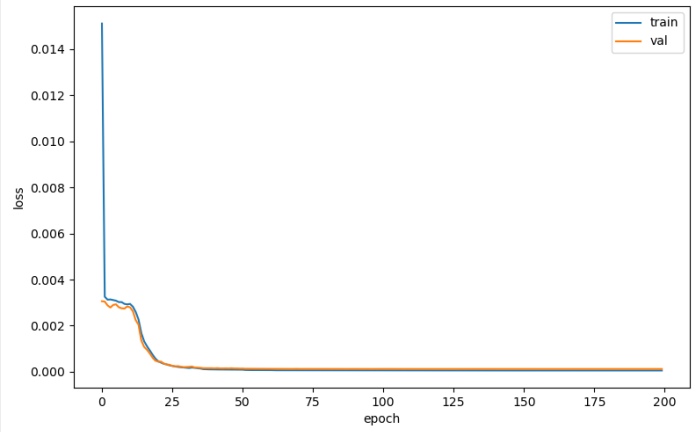

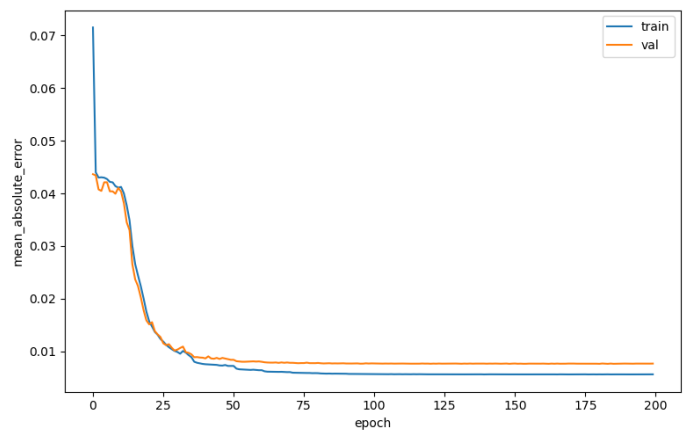

In [ ]:
# Test the model
path = '/content/drive/MyDrive/ML675 Final/dataset/'
img_size = 224
model = load_model('/content/drive/MyDrive/ML675 Final/model1.h5')
for i in range(12139):
  img = cv2.imread(path + 'image1/' + str(i) +'.jpg')
  lm = np.load(path + 'label1/' + str(i) +'.npy')
  resize_img = cv2.resize(img, (img_size, img_size))
  resize_img = np.array(resize_img, dtype=np.float64) / 255.0
  pred = model.predict(np.expand_dims(resize_img, axis=0)).reshape((68, 2))
  pred[:, 0] = pred[:, 0] * img.shape[1]
  pred[:, 1] = pred[:, 1] * img.shape[0]
  
  for j in pred:
      cv2.circle(img, center=(int(j[0]), int(j[1])), radius=1, color=[255, 0, 0], thickness=-1)
  for j1 in lm:
      cv2.circle(img, center=(int(j1[0]), int(j1[1])), radius=1, color=[0, 0, 255], thickness=-1)
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

# We show the test results in the "Results" part

## Result

**1.Show the model prediction results:**

The CNN prediction result: (the red points are the true value, the blue points are the model prediction result)

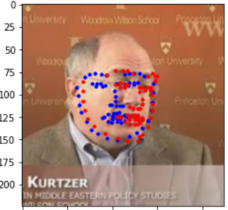

The CNN+Transformer prediction result: (the red points are the true value, the blue points are the model prediction resutls)

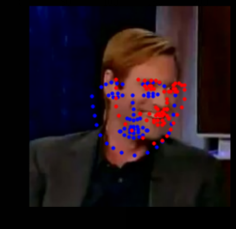

The Residual Nerual Network result: (the red points are the true values, the blue points are the model prediction resutl)

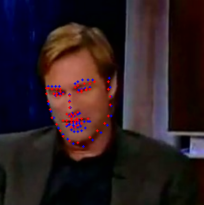

**2.Camparing the MSE and NME values of three models:**
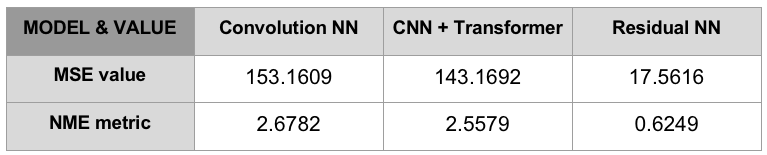

In the form, we use MSE to evaluate the model performance on the training set and NME to evaluate the model performance on the test set.

For the Residual Neural Network, we further plot the MSE and MAE value of the train and test dataset [in "Method" above](#scrollTo=RO_kP1fmkWWk&line=16&uniqifier=1).

**3. Analysis the results**

According to the results, we can notice that the CNN and CNN+transformer models does not perform good on the dataset, but the Residual Neural Network has a perfect performance.

*Reason1:* The Residual Neural Network will focus on the slight difference between the actual and predicted values.

*Reason 2 :* In Residual Neural Network, the ‘skip connection’ can help us take activation from one layer and feed it into another layer even though the model is very deep. Thus we can sustain the learning parameters.

*Reason 3 :* The Residual Neural Network can avoid vanishing gradient.

*Reason 4 :* The constructions of the CNN and CNN+Transformer are unreasonable, especially for the dropout value in the CNN and CNN+Transformer models.

For the CNN and CNN+Transformer models, the models are underfitting. We tried to use other data pre-processing ways, adjust the model construction and use different hyperparameters, but finally, the CNN and CNN+Transformer models still have an underfitting problem. Thus, we use Residual Neural Network model.

**4. Other Development**

We use the Residual Neural Network to do some reality experiments based on our team members. We upload four facial pictures of our team without any blocks and one with a facial mask. The results are blow.

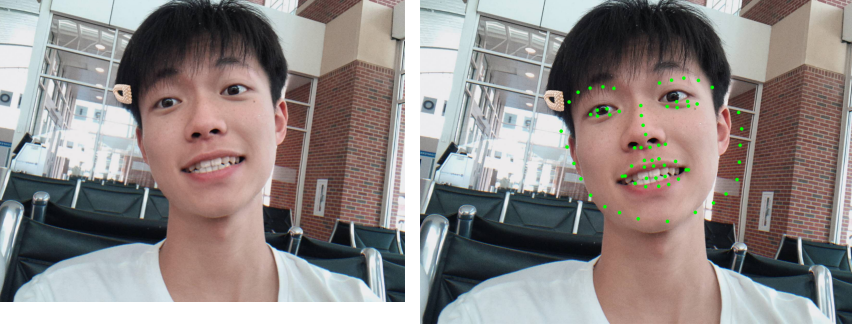

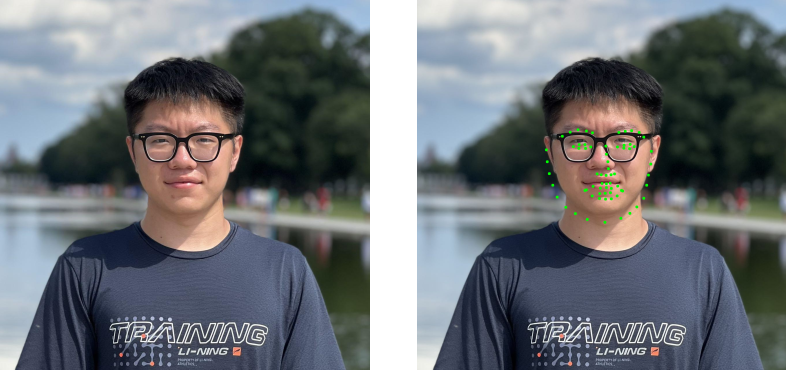

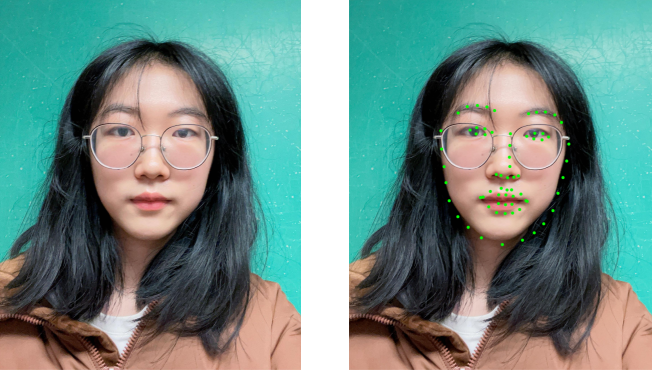

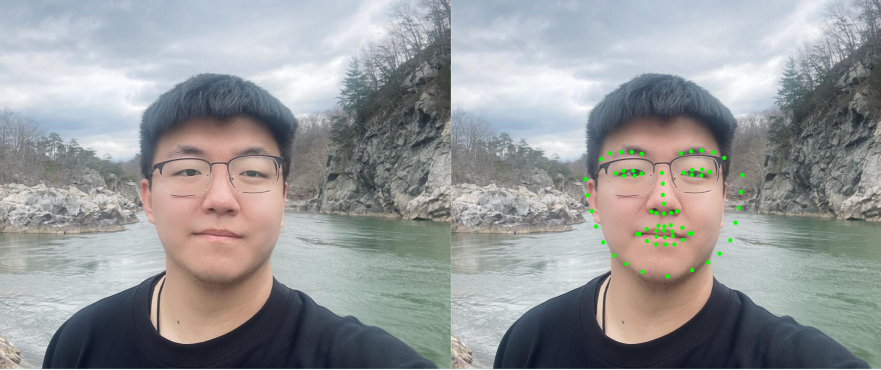

When we apply the Residual Neural Network on a facial picture with a mask, the prediction result is inaccurate.

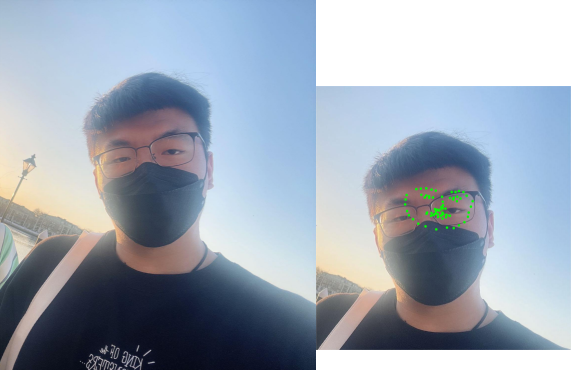

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?

1. Neural Network (CNN, Transformer). We built our model by different neural network architectures (CNN, CNN + Transformer, Residual Neural Network)

What aspects of your project did you find most surprising?

2. Our Residual Neural Network model performs much better than CNN and CNN + Transformer models. Moreover, the CNN + Transformer model does not markedly perform better than the CNN model.

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

3. One lesson we learned is that we need to preprocess the dataset carefully. We failed to train our model several times because of inappropriate data preprocessing methods. For example, initially, we did not resize the images to the same size, causing trouble when we implemented our neural network model and visualized our result. Then we made another mistake: we stored our resized image in npz file format, which should be jpg format, making our memory usage extremely large and running time incredibly long when training the network. So, we think preprocessing is one of the most critical steps for the ML project. We believe we can preprocess the data better in the next project.

What was the most helpful feedback you received during your presentation? Why?

4. Feedback: We need to know why Residual Neural Network can avoid vanishing gradient problems. 
   Why: It helps us to explain why our Residual Neural Network model performs  substantially better than CNN model and CNN + Transformer model

If you had two more weeks to work on this project, what would you do next? Why?

5. We will try to build a Residual Neural Network + Transformer model because CNN + Transformer model did not perform well in our project. So, we want to add a Transformer in Residual Neural Network to see whether Transformer can improve the performance on facial landmarks detection.